In [1]:
from include.TriggerPrimitive import TriggerPrimitive as TriggerPrimitive
import numpy as np
import matplotlib.pyplot as plt
from include.TPFinder import TPFinder
import os

In [40]:
def TPFinder(waveform, thresh):

    is_hit = False

    hit_charge =[]    
    this_hit = TriggerPrimitive()
    start_adc = []
    end_adc=[]
    hits = []
    true_adc_areas = []
    

    for tick, adc  in enumerate(waveform):
    
        if (adc > thresh and is_hit==False):
            is_hit = True
            this_hit.time_start =tick
            temp_tick = tick
            start_adc.append(adc)
            while (waveform[temp_tick]>0):
                temp_tick = temp_tick - 1
            first_zero = temp_tick
            mean_noise = np.mean(waveform[first_zero-10:first_zero])
            temp_tick = tick
            while (waveform[temp_tick]>mean_noise):
                temp_tick = temp_tick - 1
            true_start = temp_tick
                
                
            
           
        if(is_hit == True):
            hit_charge.append(adc)
           
        if (is_hit and adc<=thresh):
            time_end  = tick
            is_hit = False
            temp_tick_f = tick
            end_adc.append(waveform[tick-1])
           
            for index, ADC in enumerate(hit_charge):
                if (ADC == np.max(hit_charge)):
                    this_hit.adc_peak = ADC
                    this_hit.time_peak = index
            this_hit.adc_integral = np.sum(hit_charge)
            this_hit.time_over_threshold = time_end - this_hit.time_start
            hits.append(this_hit)
            while(waveform[temp_tick]>mean_noise):
                temp_tick_f+=1
            true_end = temp_tick_f
           
            true_adc = 0
            for i in range(true_start,true_end):
                true_adc = true_adc + waveform[i]
            true_adc_areas.append(true_adc)

            #clean up for next hit
            hit_charge = []
            this_hit = TriggerPrimitive()
            
    return hits,true_adc_areas,start_adc,end_adc #return set of hits for waveform
    


In [3]:
labels = {
   
   -1: "multilabel",
    0: "kUnknown",
    1: "kMarley",
    2: "kAr39GenInLAr", 
    3: "kKr85GenInLAr", 
    4: "kAr42GenInLAr", 
    5: "kK42From42ArGenInLAr", 
    6: "kRn222ChainRn222GenInLAr",
    7: "kRn222ChainPo218GenInLAr", 
    8: "kRn222ChainPb214GenInLAr", 
    9: "kRn222ChainBi214GenInLAr",  
    10: "kRn222ChainPb210GenInLAr", 
    11: "kK40GenInCPA",
    12: "kU238ChainGenInCPA",
    13: "kK42From42ArGenInCPA", 
    14: "kRn222ChainPo218GenInCPA",
    15: "kRn222ChainPb214GenInCPA",
    16: "kRn222ChainBi214GenInCPA", 
    17: "kRn222ChainPb210GenInCPA", 
    18: "kRn222ChainFromBi210GenInCPA", 
    19: "kCo60GenInAPA", 
    20: "kU238ChainGenInAPA",
    21: "kRn222ChainGenInPDS",
    22: "kNeutronGenInRock"
    
    }


In [4]:
#load waveform data (100 low energy electron events, 5 - 100 MeV)
#col = np.loadtxt("/eos/home-e/evilla/dune/sn-data/standard/aggregated_prodmarley_nue_spectrum_radiological_decay0_dune10kt_refactored_1x2x6_CC-WFdump-1events_thr30/waveforms_tryWfDumper.txt")
col = np.loadtxt("/eos/user/e/evilla/dune/sn-data/waveforms_withBkg_noNoise_noPedestal.txt")
ind = np.loadtxt("data/PedSubWaveform_Induction_Dump.txt")
event = 1
threshold = 30

In [47]:
#No hits ?
count = 0
collection_counter = 0
for data in col:
    if data[2] ==2:
        collection_counter+=1
        ADCS = data[2:]
        hits,true_areas,start_adc,end_adc = TPFinder(ADCS, threshold)
        if hits == []:
            count+=1

print(f'Number of Collection Waveforms: {collection_counter}')
print(f'Number of Collection Waves that breach threshold: {collection_counter-count}')
print(f"Percentage: {((collection_counter-count)/collection_counter)*100}")
 

Number of Collection Waveforms: 1741
Number of Collection Waves that breach threshold: 190
Percentage: 10.913268236645605


In [6]:
#returns recovered area (not including adc_integral)
def recover_area(hit): 
    x1,y1,x2,y2= hit.time_start,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x =(0-y1)/slope + x1
    end_x = x1
    
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_left = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area

    #Find Equation of Negative Slope Line (Right Side)
    x1,y1,x2,y2= hit.time_start+hit.time_over_threshold-1,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x = x1
    end_x = (0-y1)/slope + x1
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_right = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area
    
    total_area = area_right+area_left
    return total_area 

In [53]:
true_labels=[]
#Calculate true area and aprixumated area

recovered_area_list = []
#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
adc_plus_recovered = []
approximated_error = []
adjusted_approximated_error = []
adjusted_approximated_fraction = []

adc_integral_error = []
adc_real_fraction = []
approximated_real_fraction = []
approximated_fraction = []
recover_over_adc = []
adc_over_recover = []
adc_over_approximate = []
approx_over_true_bkgs = {key: [] for key in labels}
approx_over_true_bkgs_limited = {key: [] for key in labels}

adc_true_fraction = {key: [] for key in labels}
adc_lists = {key: [] for key in labels}
approximated_lists =  {key: [] for key in labels}
adc_integrals = []
true_areas_list=[]
area_lost = []
counter=0
hit_counter = 0
for data in col:
    if data[2] == 2: #collection plane
        counter+=1
        
        pedestal = np.mean(data[3:15])
        pedestal=0
        bkg = data[3]
        true_labels.append(bkg)
        data[2:] = data[2:] - pedestal
        
        ADCS = data[2:]
        hits,true_areas,start_adc,end_adc = TPFinder(ADCS, threshold)
        for i,hit in enumerate(hits):
            hit_counter+=1
            recovered_area = recover_area(hit)
            recovered_area_list.append(recovered_area)
            adc_integral.append(hit.adc_integral)
            adc_integral_error.append(np.abs(hit.adc_integral-true_areas[i])/true_areas[i])
            approximated_area = recovered_area + hit.adc_integral
            approximated_real_fraction.append(approximated_area/true_areas[i])
            #Strategy to cut out outliers (cant use true area)
            
            adjusted_approximated_area =  approximated_area
            if adjusted_approximated_area > hit.adc_integral*4:
                adjusted_approximated_area = hit.adc_integral/.6
            adjusted_approximated_fraction.append(adjusted_approximated_area/true_areas[i])    
            adc_plus_recovered.append(approximated_area)
            approximated_error.append(np.abs(approximated_area-true_areas[i])/true_areas[i])
            adjusted_approximated_error.append(np.abs(adjusted_approximated_area-true_areas[i])/true_areas[i])
            adc_real_fraction.append(hit.adc_integral/true_areas[i])
            
            adc_integrals.append(hit.adc_integral)
            true_areas_list.append(true_areas[i])
            area_lost.append(true_areas[i]-hit.adc_integral)
            
            approximated_fraction.append(approximated_area/true_areas[i])
            recover_over_adc.append(recovered_area/hit.adc_integral)
            adc_over_recover.append(hit.adc_integral/recovered_area)
            adc_over_approximate.append(hit.adc_integral/approximated_area)
            approx_over_true_bkgs[bkg].append(approximated_area/true_areas[i])
            if hit.adc_integral > 750:
                approx_over_true_bkgs_limited[bkg].append(hit.adc_integral/true_areas[i])
            else:
                approx_over_true_bkgs_limited[bkg].append(approximated_area/true_areas[i])
            adc_true_fraction[bkg].append(hit.adc_integral/true_areas[i])
            
            #beta distributions
            adc_lists[bkg].append(hit.adc_integral)
            approximated_lists[bkg].append(approximated_area)

        count+=1
print(counter)
print(hit_counter)

/tmp/hakins/ipykernel_965709/2486062338.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)
/tmp/hakins/ipykernel_965709/2486062338.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)
/tmp/hakins/ipykernel_965709/2200541221.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  adc_over_recover.append(hit.adc_integral/recovered_area)


1741
200


<Figure size 640x480 with 0 Axes>

200


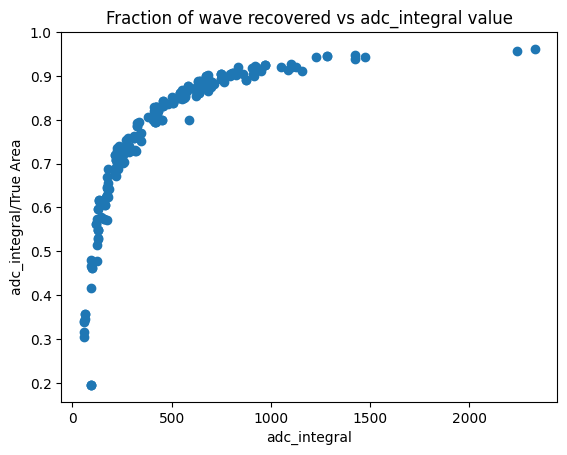

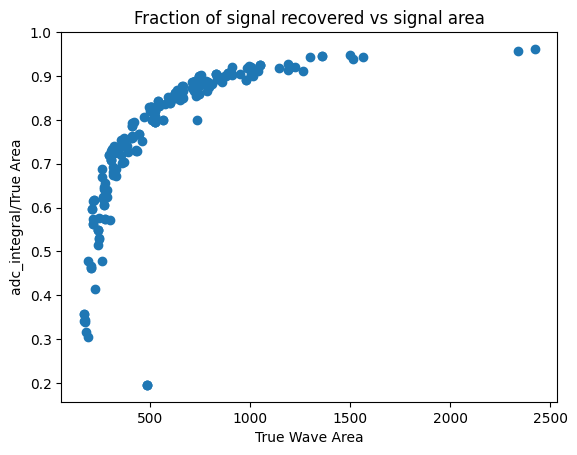

In [50]:
plt.scatter(adc_integrals, adc_real_fraction)
print(len(adc_integrals))
# Adding labels and title
plt.xlabel('adc_integral')
plt.ylabel('adc_integral/True Area')
plt.title('Fraction of wave recovered vs adc_integral value')

# Display the plot
plt.show()
plt.clf()

plt.scatter(true_areas_list, adc_real_fraction)

# Adding labels and title
plt.xlabel('True Wave Area')
plt.ylabel('adc_integral/True Area')
plt.title('Fraction of signal recovered vs signal area')

# Display the plot
plt.show()


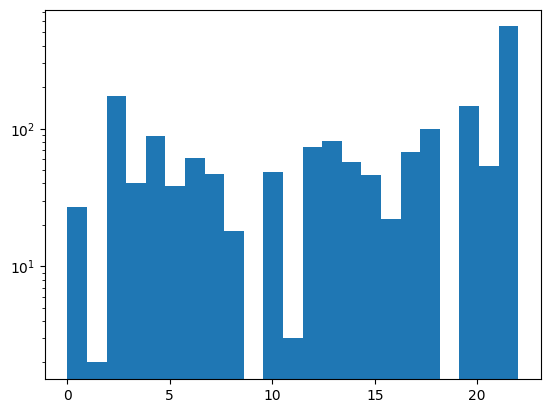

In [30]:
plt.hist(true_labels,bins=23)
plt.yscale('log')


Text(0, 0.5, 'Number of Hits')

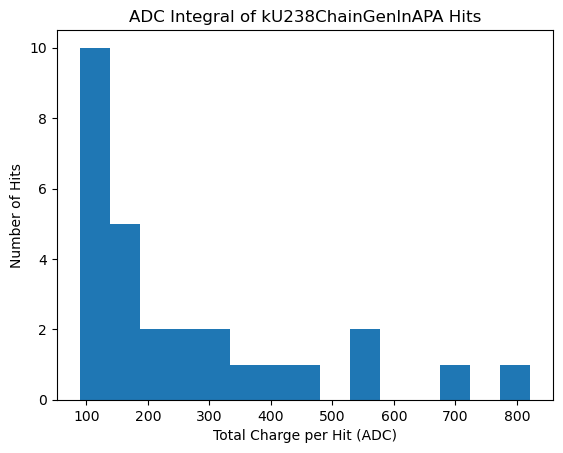

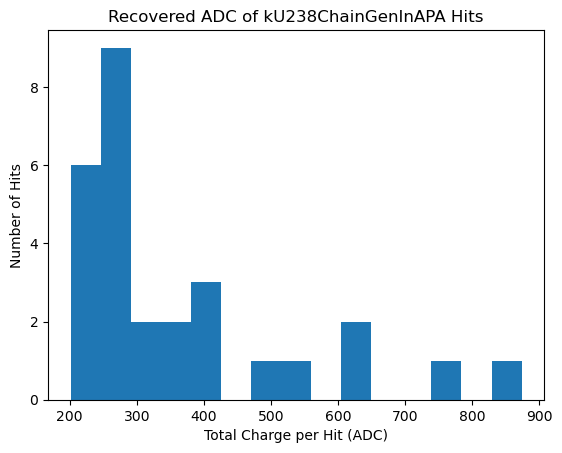

In [ ]:
bins=15
plt.hist(adc_lists[20], bins=bins)
plt.title("ADC Integral of kU238ChainGenInAPA Hits")
plt.xlabel("Total Charge per Hit (ADC)")
plt.ylabel("Number of Hits")
fig = plt.figure()
plt.hist(approximated_lists[20],bins=bins)
plt.title("Recovered ADC of kU238ChainGenInAPA Hits")
plt.xlabel("Total Charge per Hit (ADC)")
plt.ylabel("Number of Hits")

24
24


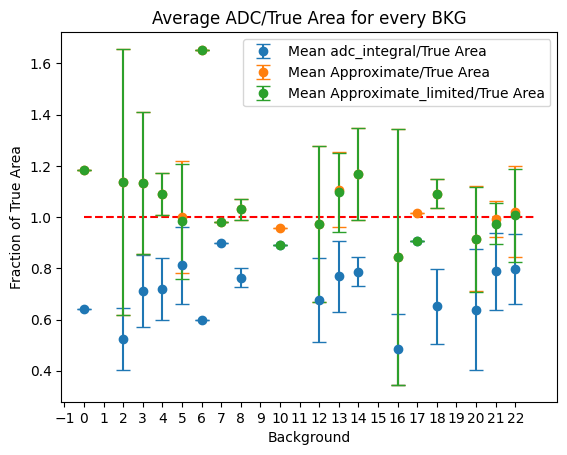

In [55]:
average_adc_true_fractions = []
approx_true_fractions = []
approx_true_fractions_limited = []
stds = []
stds_approx = []
stds_approx_limited = []

for key in adc_true_fraction:
    average_adc_true_fractions.append(np.mean(adc_true_fraction[key]))
    stds.append(np.std(adc_true_fraction[key]))
    approx_true_fractions.append(np.mean(approx_over_true_bkgs[key]))
    stds_approx.append(np.std(approx_over_true_bkgs[key]))
    approx_true_fractions_limited.append(np.mean(approx_over_true_bkgs_limited[key]))
    stds_approx_limited.append(np.std(approx_over_true_bkgs_limited[key]))
    

    
print(len(adc_true_fraction.keys()))
print(len(average_adc_true_fractions))

'''
bin_edges = np.arange(-0.5, 23.5, 1)
plt.hist(true_labels, bins=bin_edges)
plt.yscale('symlog', linthresh=1)'''

plt.errorbar(adc_true_fraction.keys(),average_adc_true_fractions,yerr=stds,capsize=5, fmt="o", label="Mean adc_integral/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.hlines(y=1,xmin=0,xmax=23, linestyles='dashed', colors='red')
plt.xticks(ticks=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
plt.legend()

plt.errorbar(adc_true_fraction.keys(),approx_true_fractions,yerr=stds_approx,capsize=5, fmt="o", label="Mean Approximate/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.legend()

plt.errorbar(adc_true_fraction.keys(),approx_true_fractions_limited,yerr=stds_approx_limited,capsize=5, fmt="o", label="Mean Approximate_limited/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.legend()



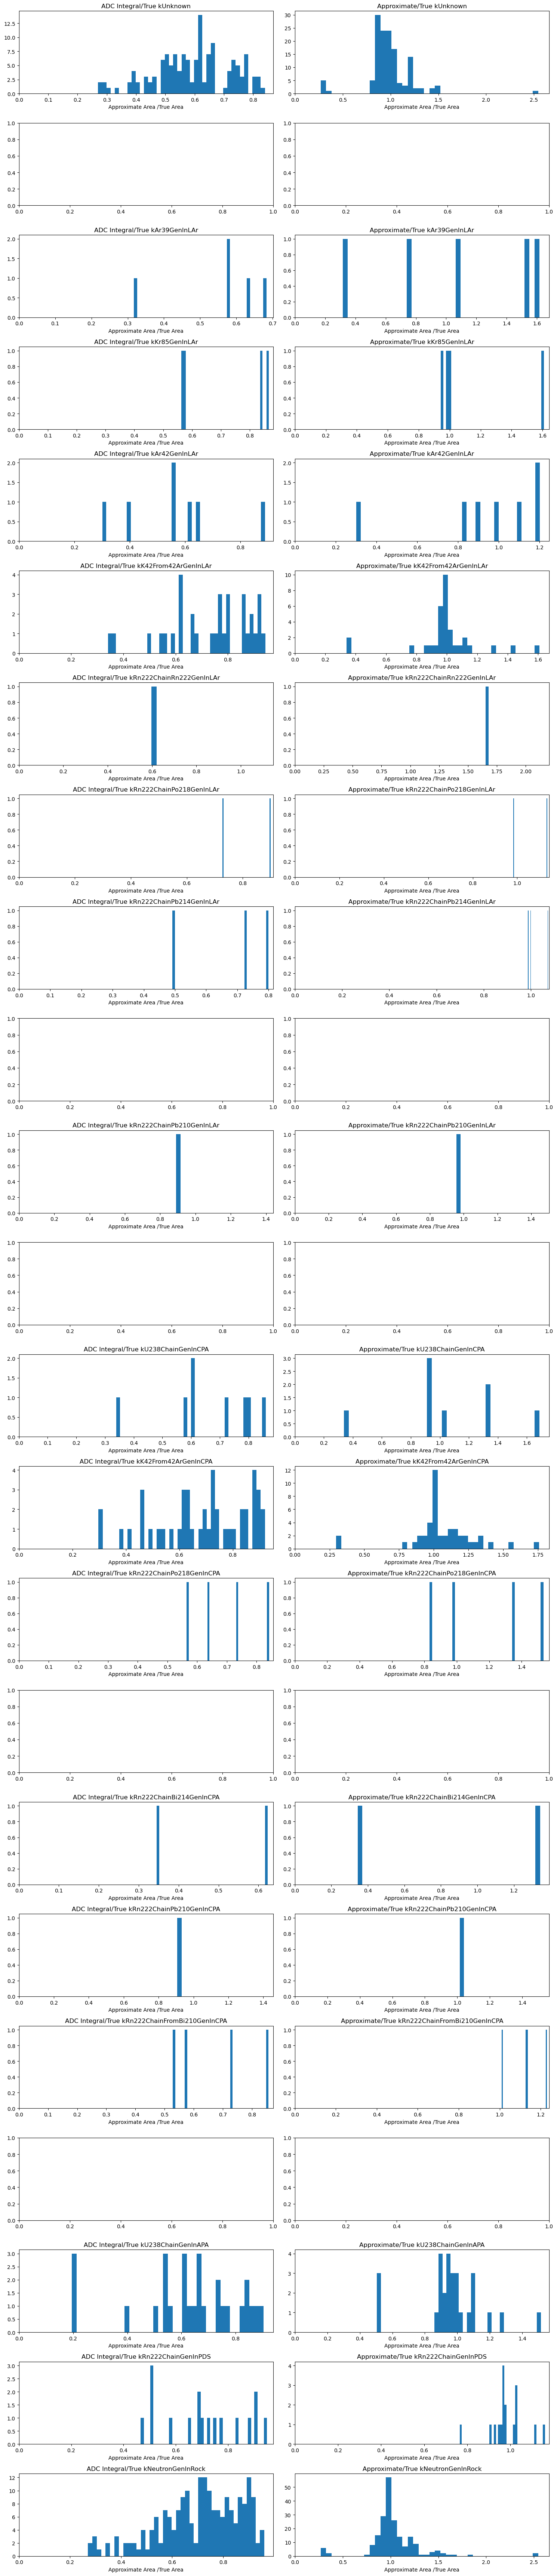

In [ ]:
# Number of plots
num_plots = 23

# Create subplots
fig, axes = plt.subplots(num_plots, 2, figsize=(15, num_plots * 3))

# Loop over the range and create the plots

for i in range(num_plots):
    # Plot for adc_true_fraction
    if len(adc_true_fraction[i])>0:
        axes[i, 0].hist(adc_true_fraction[i], bins=40)
        axes[i, 0].set_title(f"ADC Integral/True {labels[i]}")
        axes[i, 0].set_xlabel("Approximate Area /True Area")
        axes[i, 0].set_xlim(left=0)

        # Plot for approx_over_true_bkgs
        axes[i, 1].hist(approx_over_true_bkgs[i], bins=40)
        axes[i, 1].set_title(f"Approximate/True {labels[i]}")
        axes[i, 1].set_xlabel("Approximate Area /True Area")
        axes[i, 1].set_xlim(left=0)

# Adjust layout
plt.tight_layout()
plt.show()

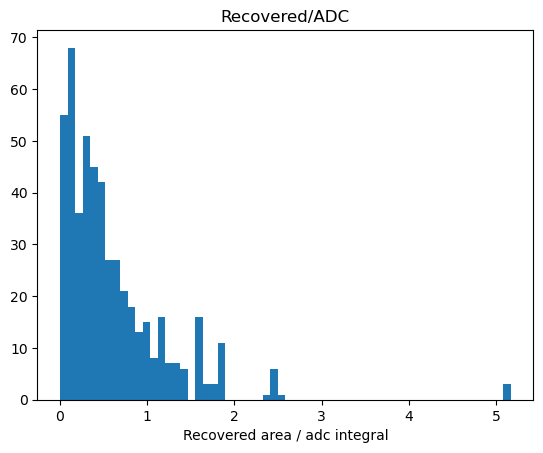

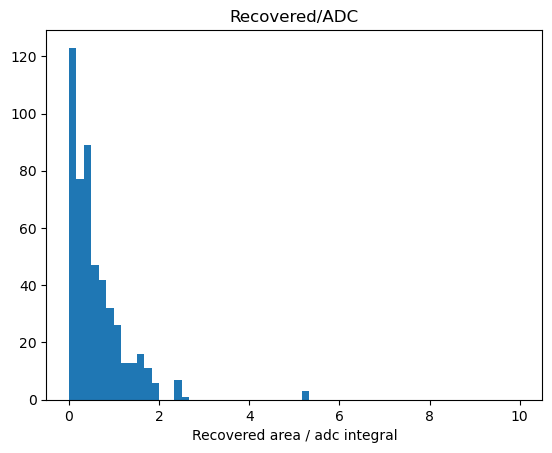

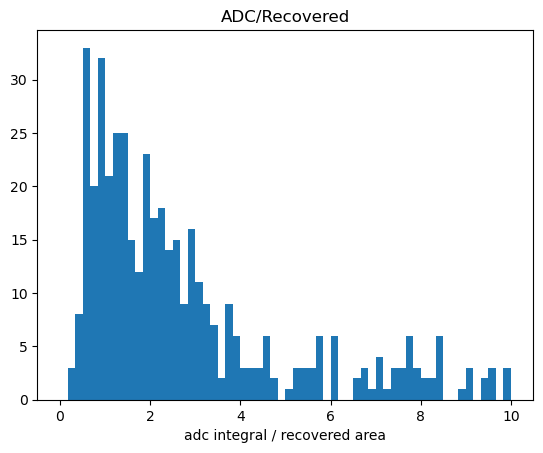

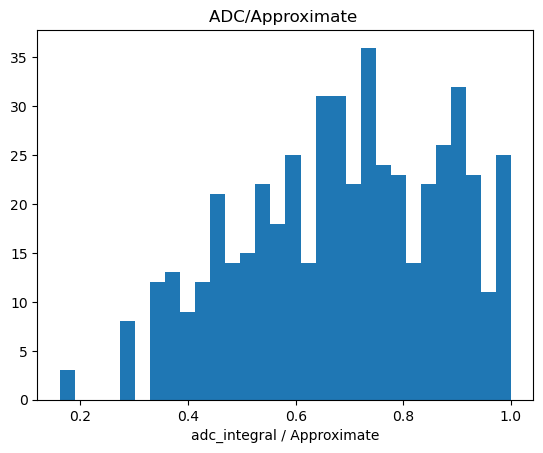

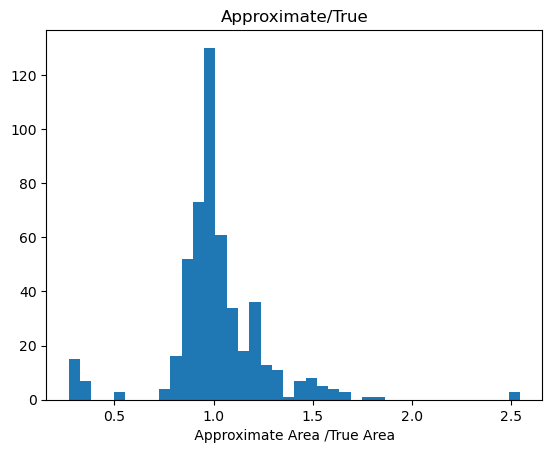

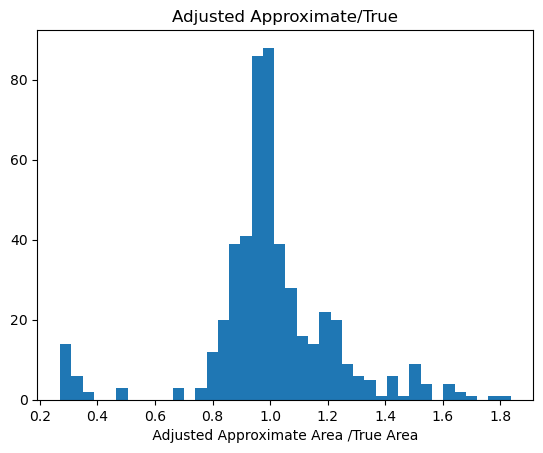

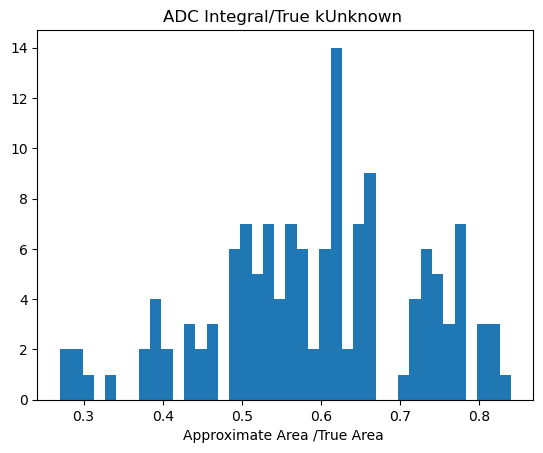

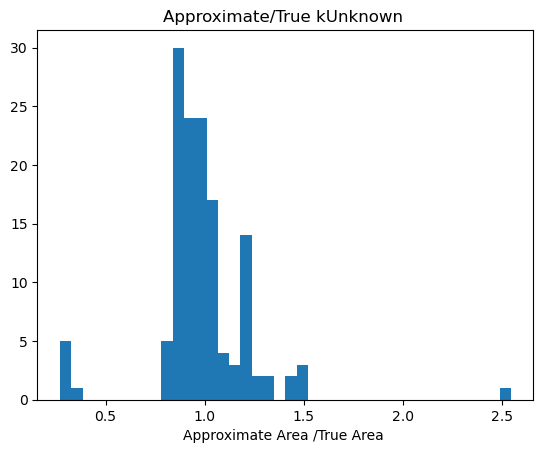

Mean ADC/Real: 0.6671350824202533
Median ADC/Real: 0.6595744680851063
Mean Approx/Real: 1.0148111590306101


In [ ]:
plt.hist(recover_over_adc,bins=60)
plt.title("Recovered/ADC")
plt.xlabel("Recovered area / adc integral")
plt.show()
plt.hist(recover_over_adc,bins=60, range=(0,10))
plt.title("Recovered/ADC")
plt.xlabel("Recovered area / adc integral")
plt.show()
plt.hist(adc_over_recover,bins=60, range=(0,10))
plt.title("ADC/Recovered")
plt.xlabel("adc integral / recovered area")
plt.show()
plt.hist(adc_over_approximate,bins=30)
plt.title("ADC/Approximate ")
plt.xlabel("adc_integral / Approximate")
plt.show()
plt.hist(approximated_fraction,bins=40)
plt.title("Approximate/True")
plt.xlabel(" Approximate Area /True Area ")
plt.show()
plt.hist(adjusted_approximated_fraction,bins=40)
plt.title("Adjusted Approximate/True")
plt.xlabel(" Adjusted Approximate Area /True Area ")
plt.show()

plt.hist(adc_true_fraction[0],bins=40)
plt.title(f"ADC Integral/True {labels[0]} ")
plt.xlabel("Approximate Area /True Area ")
plt.show()

plt.hist(approx_over_true_bkgs[0],bins=40)
plt.title(f"Approximate/True {labels[0]} ")
plt.xlabel("Approximate Area /True Area ")
plt.show()
print(f"Mean ADC/Real: {np.mean(adc_real_fraction)}")
print(f"Median ADC/Real: {np.median(adc_real_fraction)}")
print(f"Mean Approx/Real: {np.mean(approximated_fraction)}")



Mean ADC_integral Error: 0.3328649175797466
Mean Approx Error: 0.1545513642649672
Mean Adjusted Approx Error: 0.1472456676948981


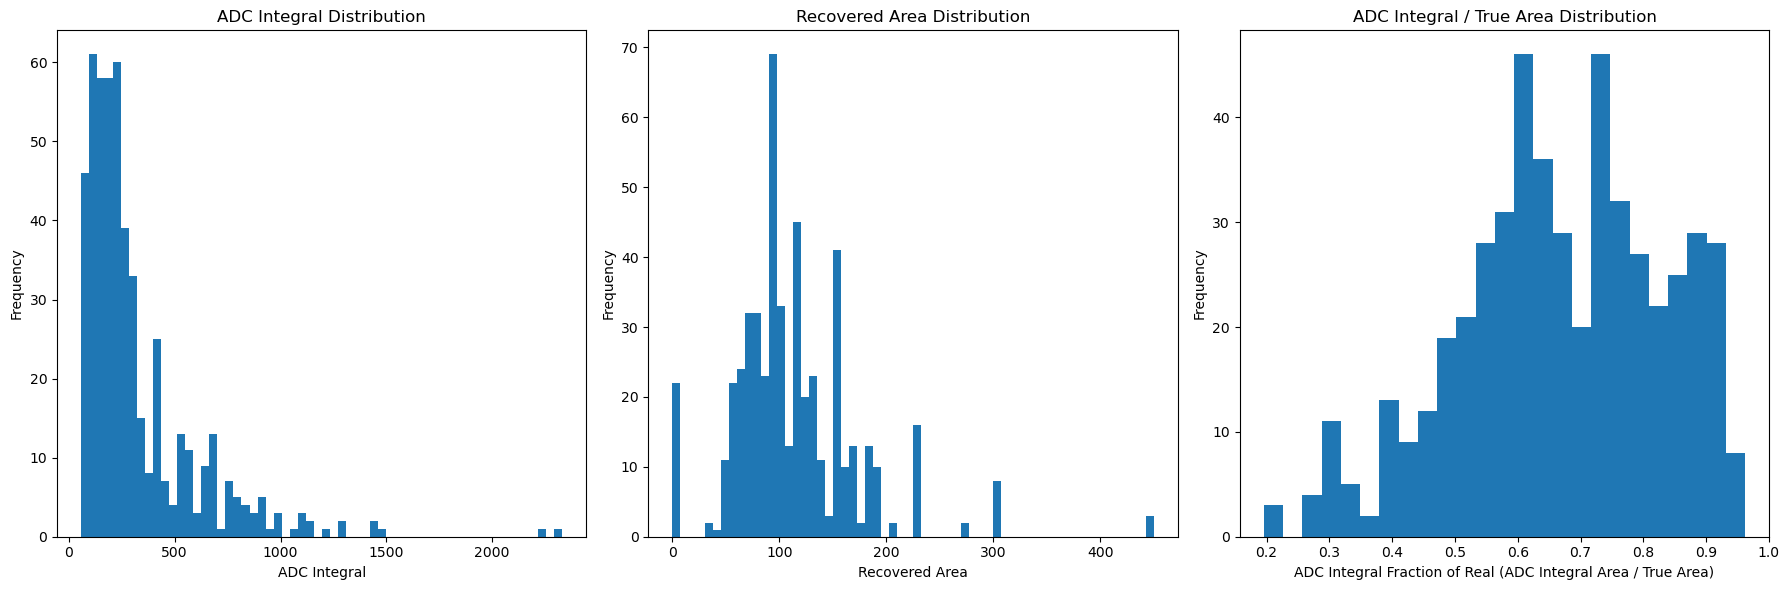

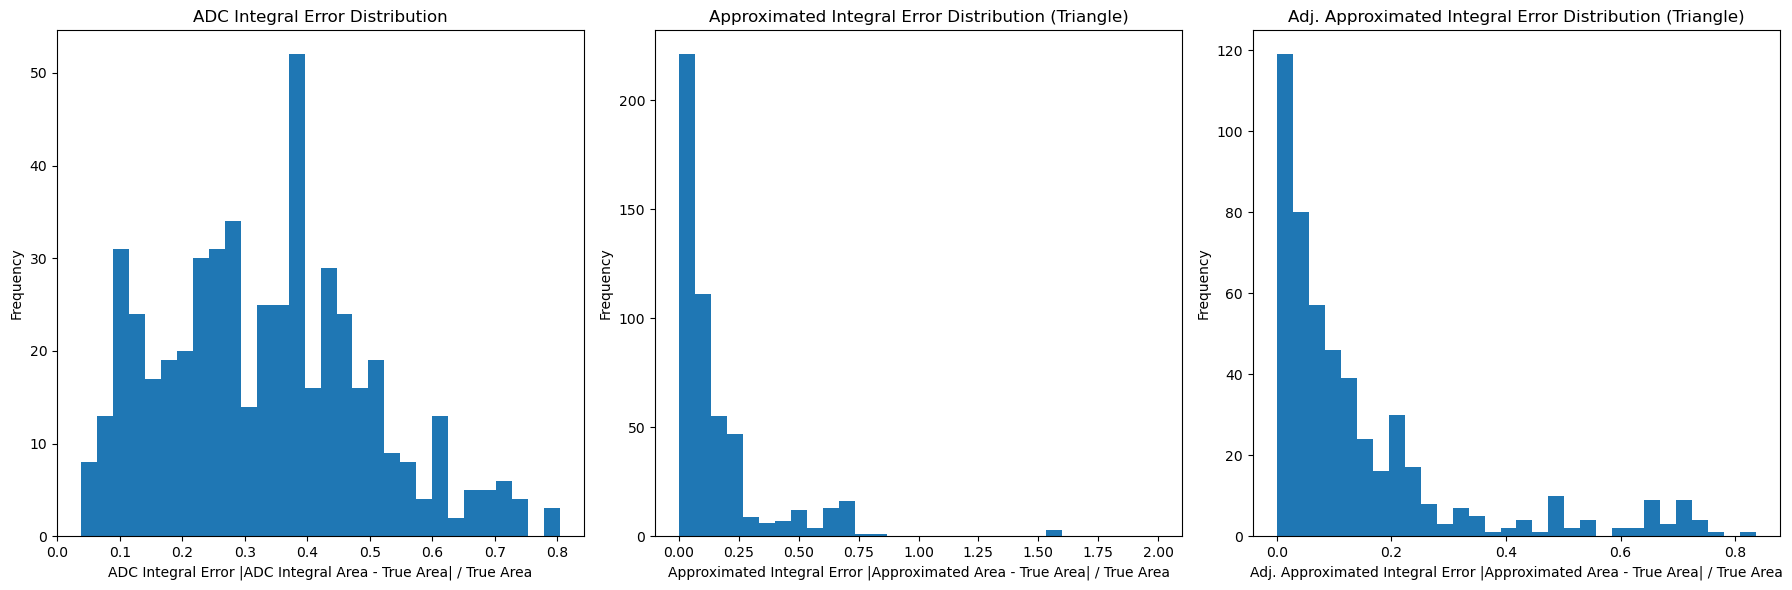

In [ ]:


# Print mean errors
print(f"Mean ADC_integral Error: {np.mean(adc_integral_error)}")
print(f"Mean Approx Error: {np.mean(approximated_error)}")
print(f"Mean Adjusted Approx Error: {np.mean(adjusted_approximated_error)}")

# Create the first set of subplots
fig, axs1 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral histogram
axs1[0].hist(adc_integral, bins=60)
axs1[0].set_title('ADC Integral Distribution')
axs1[0].set_xlabel('ADC Integral')
axs1[0].set_ylabel('Frequency')

# Recovered Area histogram
axs1[1].hist(recovered_area_list, bins=60)
axs1[1].set_title('Recovered Area Distribution')
axs1[1].set_xlabel('Recovered Area')
axs1[1].set_ylabel('Frequency')

# ADC Integral / True Area histogram
axs1[2].hist(adc_real_fraction, bins=25)
axs1[2].set_title('ADC Integral / True Area Distribution')
axs1[2].set_xlabel('ADC Integral Fraction of Real (ADC Integral Area / True Area)')
axs1[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create the second set of subplots
fig, axs2 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral Error histogram
axs2[0].hist(adc_integral_error, bins=30)
axs2[0].set_title('ADC Integral Error Distribution')
axs2[0].set_xlabel('ADC Integral Error |ADC Integral Area - True Area| / True Area')
axs2[0].set_ylabel('Frequency')

# Approximated Integral Error histogram
axs2[1].hist(approximated_error, bins=30, range=(0,2))
axs2[1].set_title('Approximated Integral Error Distribution (Triangle)')
axs2[1].set_xlabel('Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[1].set_ylabel('Frequency')

# Adj. Approximated Integral Error histogram
axs2[2].hist(adjusted_approximated_error, bins=30)
axs2[2].set_title('Adj. Approximated Integral Error Distribution (Triangle)')
axs2[2].set_xlabel('Adj. Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
def plot_dotted_line(x1, y1, x2, y2,y_max,y_min,plot):
    slope = (y2 - y1) / (x2 - x1)
    x_max = (y_max-y1)/slope + x1
    x_min = (y_min-y1)/slope + x1
    x_values = np.linspace(x_min, x_max, 100)
    y_values = slope * (x_values - x1) + y1
    if plot:
        plt.plot(x_values, y_values, 'r--',color='black')
    else:
        return [x_min,x_max,slope]




Plots waveforms with important points. NOTE: adc integral does not exactly start or end at threshold, since the adc value might not land exactly on the threshold since it has a sampling rate limit. The last adc value that is added to adc_integral is the one right before adc < threshold

In [ ]:
#Plots example wave form with triangle area recovery

event = 1
threshold = 30

#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
j=0
for j,data in enumerate(col):
    if count > 40:
        break
    pedestal = np.mean(data[6:15])
    pedestal=0
    background_label = data[3]
    if np.abs(pedestal-1800) < 100: #only want to pick up collection. 1800 indicates induction
        break
    
    data[4:] = data[4:] - pedestal
    if (data[0]==event):
        ADCS = data[4:]
        hits,list,start_adc,end_adc = TPFinder(ADCS, threshold)
        #for tick, adc in enumerate(ADCS):
         #   plt.plot(tick, adc, 'o', color="lightblue", markersize=7)
        for i,hit in enumerate(hits):
            if hit.adc_peak-threshold > 1:
                plt.title(f"Collection waveforms for {labels[background_label]} (event %.0f)" %event)
                plt.plot(ADCS)#offset by channel number
                plt.plot(hit.time_start,start_adc[i] ,'o', color='red')
                plt.plot(hit.time_start+hit.time_peak,hit.adc_peak, 'o')
                plt.plot(hit.time_start+hit.time_over_threshold-1,end_adc[i], 'o',color='red',label="adc_integral range") #minus 1 because you dont include the charge once adc<thresh, see TPfinder
                plt.plot(hit.time_start,threshold,'o',color='green',label="TPs, threshold")
                plt.plot(hit.time_start+hit.time_over_threshold-1,threshold, 'o',color='green')
                plt.legend()
                plt.xlim(hit.time_start - 10, hit.time_start + hit.time_over_threshold + 10)
                

                #vertical dotted lines
                #plt.plot([hit.time_start - 0.5, hit.time_start - 0.5], [0, threshold], 'r--')
                #plt.plot([hit.time_start - 0.5 + hit.time_over_threshold, hit.time_start - 0.5 + hit.time_over_threshold], [0, threshold], 'r--')
    
                #traingle dotted lines
                # Plotting the dotted lines
                pos_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start, threshold,hit.adc_peak,0]
                plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],True)
                neg_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start + hit.time_over_threshold-1, threshold,hit.adc_peak,0]
                plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],True)
                #plt.plot([34,hit.time_start - 0.5], [hit.adc_peak, threshold], 'r--', color='black')
                #plt.plot([34, hit.time_start - 0.5 + hit.time_over_threshold], [hit.adc_peak, threshold], 'r--',color='black')
                
                #adding text
                #plt.text(hit.time_start - 0.5 - 1, threshold, '(time_start, threshold)', fontsize=9, ha='right')
                plt.text(hit.time_start+hit.time_peak, hit.adc_peak, '(time_peak,adc_peak)', fontsize=9, ha='right')
                #plt.text(hit.time_start - 0.5 + hit.time_over_threshold+30, threshold, '(time_start + time_over_threshold, threshold)', fontsize=6.5, ha='right')
                
                #shading adc_integral area
                x_positions = np.arange(len(ADCS))
                start = (hit.time_start)
                end = (hit.time_start + hit.time_over_threshold-1)
                for i in range(start, end + 1):
                    plt.bar(i, ADCS[i], color='gray', alpha=.5,width=1)
                    
                '''plt.fill_between(
                x_positions, 0, ADCS,
                where=(x_positions >= start) & (x_positions <= end),
                color='gray', alpha=0.5, label='Shaded Region')'''

                adc_integral.append(hit.adc_integral)
                count+=1
                
                #shading traingle arae
                args = plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],False)

                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(x_min,hit.time_start,100)
                y_values = slope * (x_values - hit.time_start) + threshold
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')
                args = plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],False)

                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(hit.time_start+hit.time_over_threshold-1,x_min,100)
                y_values = slope * (x_values - (hit.time_start+hit.time_over_threshold-1)) + threshold
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')


                adc_integral.append(hit.adc_integral)
                count+=1
                plt.ylabel("Offset Amplitude [ADC]")
                plt.xlabel("Time [ticks]")
                os.makedirs(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/with_bkg/{labels[background_label]}', exist_ok=True)
                #plt.savefig(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/{i}_{j}_signal.png')

                plt.savefig(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/with_bkg/{labels[background_label]}/{i}_{j}_signal.png')
                plt.clf()
                
    
           
        #plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
        offset+=100
        
plt.show()



#plot induction waveforms for event
for data in col:
    if (background_label==11):
        ADCS = data[2:]
        plt.title("Col waveforms (event %.0f)" %event)
        plt.plot(ADCS + offset)#offset by channel number
        plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
        offset+=100
        plt.ylabel("Offset Amplitude [ADC]")
        plt.xlabel("Time [ticks]")
plt.show()


/tmp/hakins/ipykernel_3631231/2025387140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'r--',color='black')
/tmp/hakins/ipykernel_3631231/2025387140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'r--',color='black')
/tmp/hakins/ipykernel_3631231/2025387140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'r--',color='black')
/tmp/hakins/ipykernel_3631231/2025387140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, y_v

<Figure size 640x480 with 0 Axes>